In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import cv2 
from PIL import Image
from matplotlib import pyplot as plt 

In [2]:
from tqdm import tqdm

In [3]:
Old_Im=[]
Finals=[]
for i in range(1,10):
    final = np.array(Image.open("data/CALSPAR_init_Mines/crystal_825x300x950_8bits_binary_00"+str(i)+".tiff"))
    start= np.array(Image.open("data/CALSPAR_init_Mines/crystal_825x300x950_8bits_greyscale_00"+str(i)+".tiff"))
    Finals.append(final)
    Old_Im.append(cv2.fastNlMeansDenoising(start, None, 20, 7, 21))
for i in range(10,100):
    final = np.array(Image.open("data/CALSPAR_init_Mines/crystal_825x300x950_8bits_binary_0"+str(i)+".tiff"))
    start= np.array(Image.open("data/CALSPAR_init_Mines/crystal_825x300x950_8bits_greyscale_0"+str(i)+".tiff"))
    Finals.append(final)
    Old_Im.append(cv2.fastNlMeansDenoising(start, None, 20, 7, 21))
for i in tqdm(range(100,951)):
    final = np.array(Image.open("data/CALSPAR_init_Mines/crystal_825x300x950_8bits_binary_"+str(i)+".tiff"))
    start= np.array(Image.open("data/CALSPAR_init_Mines/crystal_825x300x950_8bits_greyscale_"+str(i)+".tiff"))
    Finals.append(final)
    Old_Im.append(cv2.fastNlMeansDenoising(start, None, 20, 7, 21))

100%|██████████| 851/851 [06:37<00:00,  2.14it/s]


In [4]:
def histogramme(img):
    histo=[0]*256
    for line in img:
        for pixel in line:
            histo[pixel]+=1
    plt.bar(range(256),histo)
    plt.show()
    
def histo(img):
    histo=[0]*256
    for line in img:
        for pixel in line:
            histo[pixel]+=1
    return np.array(histo)
def seg(img):
    hstg=histo(img)
    somme=sum(hstg)
    s=0
    for i,c in enumerate(hstg):
        s+=(i+1)*c
    s=s/somme
    return s

def image_segmente(img,mid):
    n,m=len(img),len(img[0])
    
    r=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if img[i][j]>=mid:
                r[i][j]=255
            else:
                r[i][j]=0
    return r

In [5]:
def seg_detect(img_gray,img_seg):
    frontier=0
    for i in range(len(img_seg)):
        for j in range(len(img_seg[0])):
            if img_seg[i][j]==0:
                if img_gray[i][j]>frontier:
                    frontier=img_gray[i][j]
    return frontier

In [6]:
seg_detect(Old_Im[0],Finals[0])

146

In [7]:
seg(Old_Im[0])

91.27584242424243

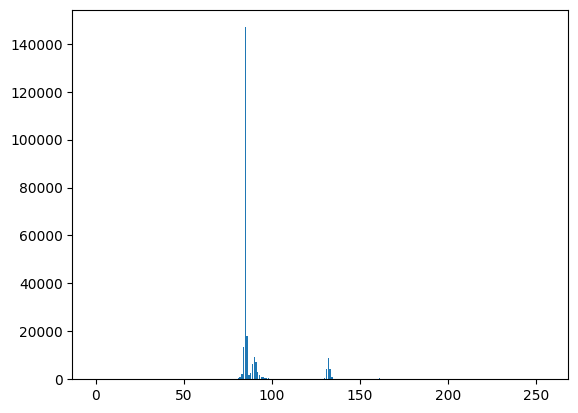

In [8]:
histogramme(Old_Im[0])

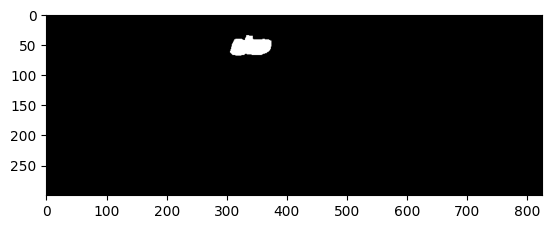

In [9]:
plt.imshow(Finals[0],cmap='gray')

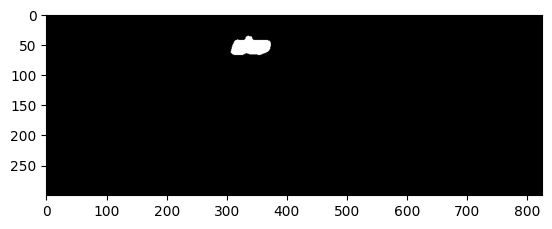

In [10]:
plt.imshow(image_segmente(Old_Im[0],146),cmap='gray')

In [11]:
data=[]
y=[]
for i in tqdm(range(950)):
    data.append(histo(Old_Im[i]))
    y.append(seg_detect(Old_Im[i],Finals[i]))

100%|██████████| 950/950 [12:43<00:00,  1.24it/s]


In [12]:
tor_data=torch.tensor(data,dtype=torch.float32)
tor_y=torch.tensor(y,dtype=torch.float32)

C:\Users\dell\AppData\Local\Temp\ipykernel_6220\4119166571.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  tor_data=torch.tensor(data,dtype=torch.float32)


In [13]:
tor_y=tor_y/255

In [14]:
tor_data=tor_data/255

In [41]:
n_input,n_hidden,n_out=256,1000,1
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden, 10),
                      nn.ReLU(),
                      nn.Linear(10, n_out),
                      )
batch_size, learning_rate =950,0.005
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [42]:
losses = []
for epoch in tqdm(range(1000)):
    pred_y = model(tor_data)
    loss = loss_function(pred_y, tor_y)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

100%|██████████| 1000/1000 [06:55<00:00,  2.41it/s]


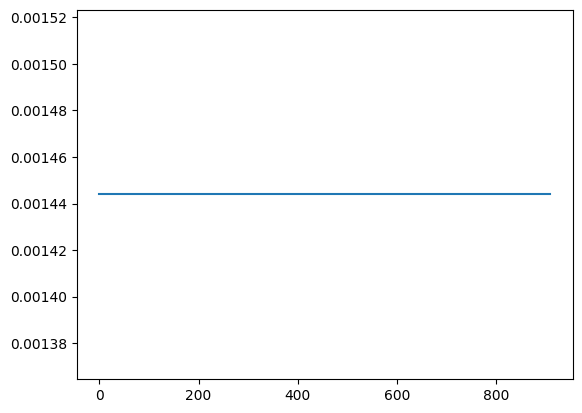

In [54]:
plt.plot(losses[:])

In [45]:
float(model(torch.tensor(histo(Old_Im[100]),dtype=torch.float32)))*255

147.74733513593674

In [46]:
seg_detect(Old_Im[100],Finals[100])

183

In [55]:
errors=[]
NEW=[]
for i in tqdm(range(150)):
    mid=float(model(torch.tensor(histo(Old_Im[i]),dtype=torch.float32)))*255
    new_im=image_segmente(Old_Im[i],mid)
    NEW.append(new_im)
    errors.append(np.sum(np.abs(new_im- Finals[i]*255 )))

100%|██████████| 150/150 [02:23<00:00,  1.05it/s]


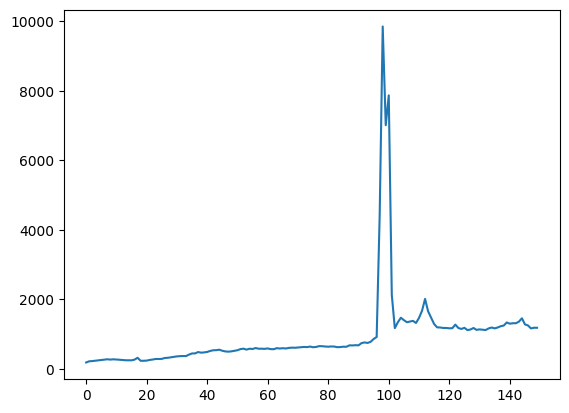

In [56]:
plt.plot(np.array(errors)//255)

In [22]:
np.sum(np.abs(new_im- Finals[i]*255 ))

302175.0

In [27]:
print(np.array(errors[0])//255)

187.0


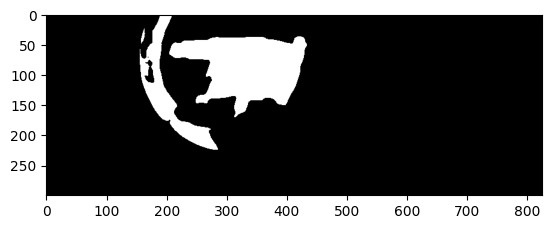

In [33]:
plt.imshow(NEW[100],cmap='gray')

In [38]:
float(model(torch.tensor(histo(Old_Im[100]),dtype=torch.float32)))*255

147.74821668863297

In [39]:
seg_detect(Old_Im[0],Finals[0])

146